## Problem Statement

The e-commerce business is quite popular today. Here, you do not need to take orders by going to each customer. A company launches its website to sell the items to the end consumer, and customers can order the products that they require from the same website. Famous examples of such e-commerce companies are Amazon, Flipkart, Myntra, Paytm and Snapdeal.

Suppose you are working as a Machine Learning Engineer in an e-commerce company named 'Ebuss'. Ebuss has captured a huge market share in many fields, and it sells the products in various categories such as household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products and health care products.

With the advancement in technology, it is imperative for Ebuss to grow quickly in the e-commerce market to become a major leader in the market because it has to compete with the likes of Amazon, Flipkart, etc., which are already market leaders.

As a senior ML Engineer, you are asked to build a model that will improve the recommendations given to the users given their past reviews and ratings.

In order to do this, you planned to build a sentiment-based product recommendation system, which includes the following tasks.

Data sourcing and sentiment analysis Building a recommendation system Improving the recommendations using the sentiment analysis model Deploying the end-to-end project with a user interface

This notebook consists of following sections that implement the full pipeline end-to-end:¶

1. Imports & Setup
2. Load Data
3. Exploratory Data Analysis & Preprocessing
4. Text Cleaning
5. Class Imbalance Handling
6. Feature Extraction & Train/Test Split
7. Model Building & Hyperparameter Tuning
8. Recommendation Systems: UBCF & IBCF
9. Top‑20 & Top‑5 with Sentiment Re‑ranking
10. Flask App Demonstration
11. Deployment Link

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 1. Imports & Setup

In [2]:
#general purpose libraries
import re
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
import warnings
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 300)
pd.set_option("display.precision", 2)

In [3]:
# NLTK libraries
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [4]:
#Modelling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

### 2. Loading the Dataset

In [5]:
import sklearn
print(sklearn.__version__)
print(np.__version__)
print(pd.__version__)
print(nltk.__version__)

1.6.1
2.0.2
2.2.2
3.9.1


In [6]:
# Constants
RANDOM_STATE = 42

# importing dataset
df_reviews = pd.read_csv("/content/gdrive/MyDrive/capstone/sample30.csv")
df_reviews.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Movie Bundles & Collections,CDs & Vinyl,Rap & Hip-Hop,Bass,Music on CD or Vinyl,Rap,Hip-Hop,Mainstream Rap,Pop Rap",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part of a promotion.,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Cookies & Chips,Rice Cakes,Cakes",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did ...",Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Spermicide,Health,Sexual Wellness,Lubricants",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,NaN,NaN,walker557,Negative


### 3. Exploratory Data Analysis - Data Cleaning and Preprocessing

In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [8]:
def calcMissingRowCount(df):
    # summing up the missing values (column-wise) and displaying fraction of NaNs
    return df.isnull().sum()

calcMissingRowCount(df_reviews)

,0
id,0
brand,0
categories,0
manufacturer,141
name,0
reviews_date,46
reviews_didPurchase,14068
reviews_doRecommend,2570
reviews_rating,0
reviews_text,0


In [9]:
# Remove the missing row of user_sentiment
df_reviews = df_reviews[~df_reviews.user_sentiment.isnull()]

In [10]:
#map the categorical user_sentiment to numerical 1 or 0 for modelling
df_reviews['user_sentiment'] = df_reviews['user_sentiment'].map({'Positive':1,'Negative':0})

In [11]:
#get the value count of user_sentiments column
df_reviews["user_sentiment"].value_counts(normalize=True)

,proportion
user_sentiment,
1,0.89
0,0.11


<Axes: xlabel='user_sentiment', ylabel='count'>

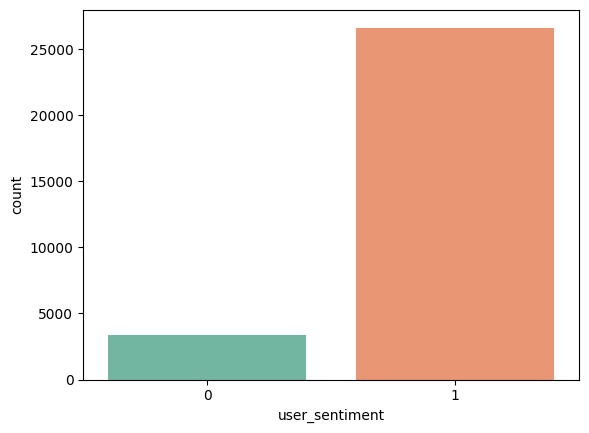

In [12]:
#Visualize using count plot
sns.countplot(x='user_sentiment', data= df_reviews, palette="Set2")

We can see overrepresentation of positive reviews. we may have to do Class Imbalance techniques during modelling.

In [13]:
df_reviews["reviews_rating"].describe()

,reviews_rating
count,29999.00
mean,4.48
std,0.99
min,1.00
25%,4.00
50%,5.00
75%,5.00
max,5.00


In [14]:
df_reviews["reviews_rating"].value_counts()

,count
reviews_rating,
5,20830
4,6020
1,1384
3,1345
2,420


<Axes: xlabel='reviews_rating', ylabel='count'>

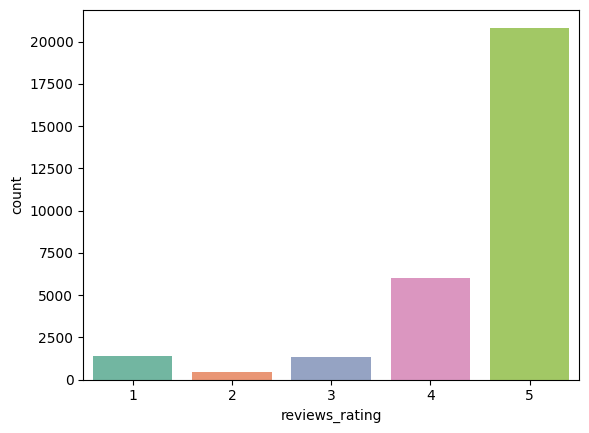

In [15]:
#visualize the user_rating..
sns.countplot(x='reviews_rating', data= df_reviews, palette="Set2")

In [16]:
df_reviews[df_reviews["user_sentiment"]==1]["reviews_rating"].describe()

,reviews_rating
count,26632.00
mean,4.56
std,0.87
min,1.00
25%,4.00
50%,5.00
75%,5.00
max,5.00


In [17]:
df_reviews[df_reviews["user_sentiment"]==0]["reviews_rating"].describe()

,reviews_rating
count,3367.00
mean,3.87
std,1.54
min,1.00
25%,3.00
50%,5.00
75%,5.00
max,5.00


In [18]:
df_reviews[(df_reviews["user_sentiment"]==1) & (df_reviews["reviews_rating"]<4)][["reviews_title","reviews_text", "reviews_rating"]]

,reviews_title,reviews_text,reviews_rating
9,Don't buy,Got as a surprise for my husband there is nothing special about it just a lube save the money and get plain KY if you just need a lube wish I could return it for a refund,1
11,Waste of Money,Purchased this thinking it would have some sort of warming effect but it's the same as the original. Don't waste your money.,1
14,Disappointed,First time purchase of this type of product. Maybe I expected too much. Did not think there was any warming feeling at all. Left us sticky! Even after trying to was it off.,1
18,Pretty nice,"I bought this because it had better reviews than the his and hers jelly, but I feel like it didn't work that well for us. It was kind of warm-feeling, but that's about it. I guess I don't know what's supposed to happen! Lol",3
54,New formula is terrible,"I used (and loved) this product for several years until they changed it. It used to moisturize my skin and left it feeling soft. Now, it sits on top of my skin and is never absorbed. It just leaves a slimy film on my skin. I will no longer purchase this product.",1
...,...,...,...
29050,Didn't Do Much For Dryness,"I received this product from Influenster. I absolutely love the whole system together, it made my hair oil-free for 48 hours. But I expected the conditioner to do more for the dryness at the ends of my hair like advertised. I didn't really notice much of a different in dryness before and after I...",3
29051,Not the best,"I used this product for a month straight before reviewing it and I'm not really all that impressed. My hair still gets pretty oily, my ends are still dry.... I mean it cleaned my hair I guess. It's nothing spectacular really. It didn't make my hair extremely soft but it didn't make my hair feel ...",3
29053,clay conditioning,Got this item as a compliment from influenster but it really made my hair smooth and shining after the usage. This review was collected as part of a promotion.,3
29054,Eh,"I am not in love with the conditioner. The clay mask and shampoo are GREAT but I didn't feel like this did anything for my ends. I would buy the other two, but not this, probably because I have fine hair and my ends need deep conditioning. Smells great though! I got this product free for testing...",3


In [19]:
df_reviews[(df_reviews["user_sentiment"]==0) & (df_reviews["reviews_rating"]>=4)][["reviews_title","reviews_text", "reviews_rating"]]

,reviews_title,reviews_text,reviews_rating
92,hydrating but not too heavy,It hydrates my skin. It is not too thick and heavy when I put it on. This review was collected as part of a promotion.,4
96,This product has made a real difference on my skin,In only a week I can see the difference in my skin on my face. This review was collected as part of a promotion.,4
100,Noticed a difference in just two weeks!,This product has made my skin smoother and supple after only two weeks. It absorbs well and leaves no residue. This review was collected as part of a promotion.,4
106,Very rich cream,"I like to use this cream on my neck and collarbone to help keep my skin well moisturized, but it can be a little heavy for the skin on my face This review was collected as part of a promotion.",4
117,Not greasy,"I finally found a moisturizing product that will absorb completely and not leave my skin feeling like it's suffocating. I apply it, and it feels like there is nothing there but my skin looks smoother. This review was collected as part of a promotion.",4
...,...,...,...
29818,Great Product,"I received a complimentary sample of this product and it worked so well for my hair! I have very thick hair so my roots always get oily and my ends are dry, this left my hair the cleanest it's felt in a long time. Will def recommend this to my family and friends! This review was collected as par...",5
29855,Great,This has prolonged the color in my hair! Not only is my hair healthier but I think I'll have to visit my stylist less! This review was collected as part of a promotion.,5
29858,Makes my hair soft and shiny without excess oil!,"This conditioner makes my hair very soft without weighing it down! I was afraid it'd make my roots more oily and weight them down, but it doesn't one bit! My hair is colored, and it hasn't faded out the color either! I'd highly recommend giving this a try! This review was collected as part of a ...",5
29862,Great Conditioner,This conditioner has become a staple in my hair regimen This review was collected as part of a promotion.,5


In [20]:
pd.crosstab(df_reviews["user_sentiment"], df_reviews["reviews_rating"], margins=True)

reviews_rating,1,2,3,4,5,All
user_sentiment,,,,,,
0,597,140,220,550,1860,3367
1,787,280,1125,5470,18970,26632
All,1384,420,1345,6020,20830,29999


As per the above results, there looks to be mismtach between review_rating and user_sentiment. there are records that have higher user rating but user sentiment is negative and lower user rating but user sentiment is positive. We can either clean up those records or update the target column to the correct user sentiment, so that will be helpful for modelling. Here, updating the user_sentiment to 0 (but was 1) when the reviews_rating is less than 4, and updating the user_sentiment to 1(but was 0), when the reviews_rating is greater than or equal to 4

In [21]:
df_reviews.loc[(df_reviews["user_sentiment"]==1) & (df_reviews["reviews_rating"]<4), "user_sentiment"] = 0

In [22]:
df_reviews.loc[(df_reviews["user_sentiment"]==0) & (df_reviews["reviews_rating"]>=4), "user_sentiment"] = 1

In [23]:
pd.crosstab(df_reviews["user_sentiment"], df_reviews["reviews_rating"], margins=True)

reviews_rating,1,2,3,4,5,All
user_sentiment,,,,,,
0,1384,420,1345,0,0,3149
1,0,0,0,6020,20830,26850
All,1384,420,1345,6020,20830,29999


from the above table, we can see that we don't have mismatch between the reviews_rating and user_sentiment

In [24]:
df_reviews["user_sentiment"].value_counts()

,count
user_sentiment,
1,26850
0,3149


In [25]:
df_reviews["brand"].value_counts()

,count
brand,
Clorox,10585
Warner Home Video,3325
Disney,1199
L'oreal Paris,1186
FOX,887
...,...
Pacific Natural Foods,1
LDR,1
National Mfg.,1


<Axes: xlabel='brand'>

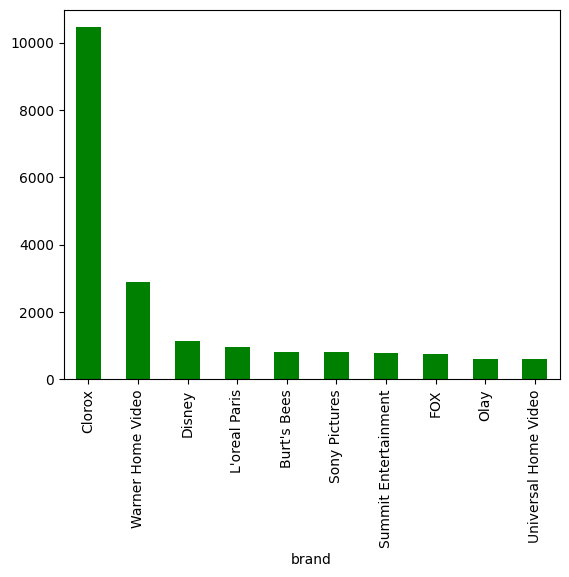

In [26]:
# Filter the top 10 brands among the positive sentiments
df_reviews[df_reviews['user_sentiment']==1].groupby('brand')['brand'].count().sort_values(ascending=False)[:10].plot(kind='bar',color='g')

<Axes: xlabel='brand'>

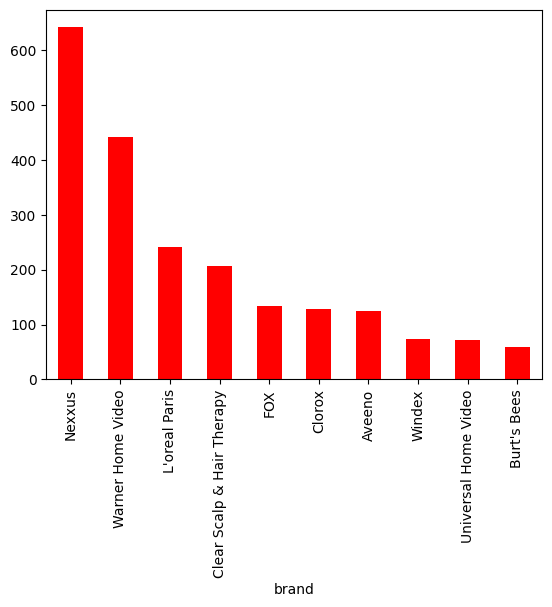

In [27]:
# Filter the top 10 brands among the negative sentiments
df_reviews[df_reviews['user_sentiment']==0].groupby('brand')['brand'].count().sort_values(ascending=False)[:10].plot(kind='bar', color='r')

In [28]:
def filter_products(productId, pos=1):
    review_count = df_reviews[(df_reviews.id==productId) & (df_reviews.user_sentiment==pos)]['brand'].count()
    return review_count

In [29]:
#group the dataframe by product id and view the # of pos review / neg reviews count
df_custom =  df_reviews.groupby('id', as_index=False)['user_sentiment'].count()
df_custom["pos_review_count"] =  df_custom.id.apply(lambda id: filter_products(id, 1))
df_custom["neg_review_count"] =  df_custom.id.apply(lambda id: filter_products(id, 0))

In [30]:
df_custom.head(10)

,id,user_sentiment,pos_review_count,neg_review_count
0,AV13O1A8GV-KLJ3akUyj,1,1,0
1,AV14LG0R-jtxr-f38QfS,2,2,0
2,AV16khLE-jtxr-f38VFn,27,10,17
3,AV1YGDqsGV-KLJ3adc-O,348,274,74
4,AV1YIch7GV-KLJ3addeG,1,1,0
5,AV1YlENIglJLPUi8IHsX,17,14,3
6,AV1YmBrdGV-KLJ3adewb,18,17,1
7,AV1YmDL9vKc47QAVgr7_,89,74,15
8,AV1Ymf_rglJLPUi8II2v,34,34,0
9,AV1Yn94nvKc47QAVgtst,25,24,1


In [31]:
#sort the product by sentiment % - postive reviews / total number of reviews
df_custom['sentiment %'] = np.round((df_custom['pos_review_count']/df_custom['user_sentiment'])*100,2)
df_custom.sort_values(by='sentiment %', ascending=False)[:20]

,id,user_sentiment,pos_review_count,neg_review_count,sentiment %
0,AV13O1A8GV-KLJ3akUyj,1,1,0,100.0
1,AV14LG0R-jtxr-f38QfS,2,2,0,100.0
4,AV1YIch7GV-KLJ3addeG,1,1,0,100.0
8,AV1Ymf_rglJLPUi8II2v,34,34,0,100.0
11,AV1Ynb3bglJLPUi8IJxJ,5,5,0,100.0
13,AV1Yo6FPglJLPUi8IK3u,1,1,0,100.0
10,AV1YnUMYglJLPUi8IJpK,1,1,0,100.0
247,AVpfml2VilAPnD_xe0m6,1,1,0,100.0
245,AVpfmVnVLJeJML43AMqC,6,6,0,100.0
45,AVpe5Mv4ilAPnD_xQQyy,4,4,0,100.0


In [32]:
df_reviews["manufacturer"].value_counts()

,count
manufacturer,
Clorox,8546
Test,3325
AmazonUs/CLOO7,2039
L'oreal Paris,1232
Walt Disney,1142
...,...
Unfi,1
LDR,1
Stanley Hardware,1


In [33]:
#Let's find out the most common users.
df_reviews["reviews_username"].value_counts()[:10]

,count
reviews_username,
mike,41
byamazon customer,41
chris,32
lisa,16
tony,15
sandy,15
rick,15
john,14
dave,14


<Axes: xlabel='reviews_username'>

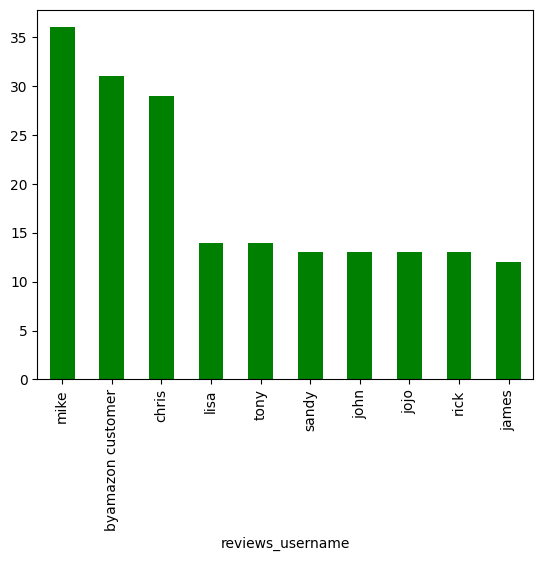

In [34]:
#plot the customers by 'positive user sentiment'
df_reviews[df_reviews['user_sentiment']==1].groupby('reviews_username')['reviews_username'].count().sort_values(ascending=False)[:10].plot(kind='bar', color='g')

<Axes: xlabel='reviews_username'>

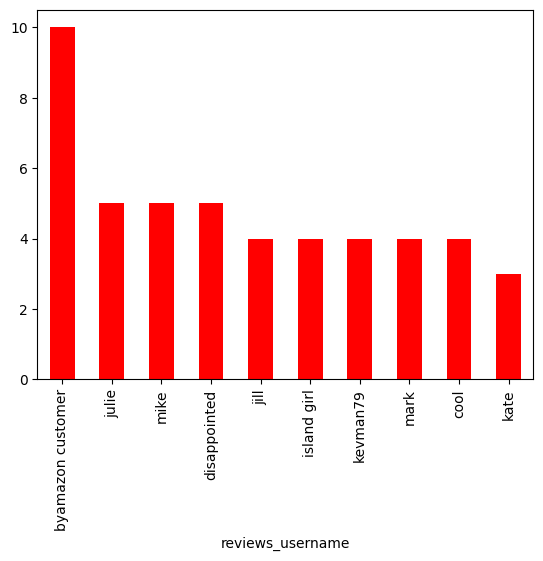

In [35]:
#plot the customers by 'negative user sentiment'
df_reviews[df_reviews['user_sentiment']==0].groupby('reviews_username')['reviews_username'].count().sort_values(ascending=False)[:10].plot(kind='bar', color='r')

In [36]:
#removing nan/null from username
df_reviews = df_reviews[~df_reviews.reviews_username.isnull()]

In [37]:
#Let's combine the reviews_text and reviews_title for better analysis
df_reviews["reviews_title"] = df_reviews["reviews_title"].fillna('')
df_reviews["reviews_full_text"] = df_reviews[['reviews_title', 'reviews_text']].agg('. '.join, axis=1).str.lstrip('. ')

In [38]:
#get the missing row cout for each of the columns
calcMissingRowCount(df_reviews)

,0
id,0
brand,0
categories,0
manufacturer,141
name,0
reviews_date,40
reviews_didPurchase,14005
reviews_doRecommend,2541
reviews_rating,0
reviews_text,0


Required columns for reviews_rating, reviews_text, user_sentiment,reviews_username doesn't have null/na values

### 4. Text Preprocessing for Modelling

In [39]:
import string

In [40]:
df_reviews[["reviews_full_text", "user_sentiment"]].sample(10)

,reviews_full_text,user_sentiment
21648,"Terrible Fragrance, Not Like Old Formula. I do not like the fragrance. The new formula is horrible. Go back to the old formula.",0
20802,"Not as good as they say!. I installed this the first of the year in 2014. ""Medium"" sized is a bit of a stretch. Wish Iwould have brought bigger because the wood splits must be small to fit in this stove.The spring handles supplied (2) never were able to stay on. The blower unit whichcame with th...",0
20621,quick accurate,1
11979,Fabulous Product. I love Clorox Disinfecting Wipes because of their powerful cleaning ability. They are easy to use and easy to find at a variety of locations. It's a product that I keep on hand at all times! This review was collected as part of a promotion.,1
28452,Horrible!. I just got this chair and have been looking for months for the perfect glider. We got it out of the box and the snaps were missing on the handles we couldn't attach the cushions. The cushions were also extremely hard. I am very dissapointed:(,0
2333,Ultimately funny. Totally not what I expected and funnier then what I thought it was. A need to see movie!!!,1
29019,"Mel-influenster Review. I received this product for free from Influenster to review. The smell of the product was good, I love the packaging as well. I loved that i didnt jave difficulty washing this conditioner out of my hair, my hair did look, smell, and feel clean. The product did not make my...",0
10109,"This product has it all. This product is convenient, works fabulously, no harsh smells or chemicals to worry about and it's cost effective!",1
25391,"I liked it.... Great movie, and I enjoyed it. Closer to the original Godzilla concept, with modern updating.",1
5708,"Fun movie. Fun story about retired spies returning to ""business"". Might work for family movie night if you don't mind blazing guns (bloodless though).",1


In [41]:
'''function to clean the text and remove all the unnecessary elements.'''
def clean_text(text):
    text = text.lower()
    text = text.strip()
    text = re.sub("\[\s*\w*\s*\]", "", text)
    dictionary = "abc".maketrans('', '', string.punctuation)
    text = text.translate(dictionary)
    text = re.sub("\S*\d\S*", "", text)

    return text

In [42]:
df_clean = df_reviews[['id','name', 'reviews_full_text', 'user_sentiment']]

In [43]:
df_clean["reviews_text"] = df_clean.reviews_full_text.apply(lambda x: clean_text(x))

In [44]:
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [45]:
stop_words = set(stopwords.words('english'))

def remove_stopword(text):
    words = [word for word in text.split() if word.isalpha() and word not in stop_words]
    return " ".join(words)

In [46]:
lemmatizer = WordNetLemmatizer()
# Lemmatize the sentence
def lemma_text(text):
    word_pos_tags = nltk.pos_tag(word_tokenize(remove_stopword(text))) # Get position tags
    # Map the position tag and lemmatize the word/token
    words =[lemmatizer.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
    return " ".join(words)

In [47]:
df_clean["reviews_text_cleaned"] = df_clean.reviews_text.apply(lambda x: lemma_text(x))

In [48]:
df_clean.head()

,id,name,reviews_full_text,user_sentiment,reviews_text,reviews_text_cleaned
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),Just Awesome. i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,1,just awesome i love this album its very good more to the hip hop side than her current pop sound so hype i listen to this everyday at the gym i give it rating all the way her metaphors are just crazy,awesome love album good hip hop side current pop sound hype listen everyday gym give rating way metaphor crazy
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good. Good flavor. This review was collected as part of a promotion.,1,good good flavor this review was collected as part of a promotion,good good flavor review collect part promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good. Good flavor.,1,good good flavor,good good flavor
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,"Disappointed. I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation...",0,disappointed i read through the reviews on here before looking in to buying one of the couples lubricants and was ultimately disappointed that it didnt even live up to the reviews i had read for starters neither my boyfriend nor i could notice any sort of enhanced or captivating sensation what w...,disappoint read review look buy one couple lubricant ultimately disappointed didnt even live review read starter neither boyfriend could notice sort enhanced captivate sensation notice however messy consistency reminiscent liquidy vaseline difficult clean pleasant especially since lack captivate...
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,Irritation. My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,0,irritation my husband bought this gel for us the gel caused irritation and it felt like it was burning my skin i wouldnt recommend this gel,irritation husband buy gel u gel caused irritation felt like burn skin wouldnt recommend gel


reviews_text is cleaned to remove stopwords, punctuations,numericals,whitespaces and lemma is derived.

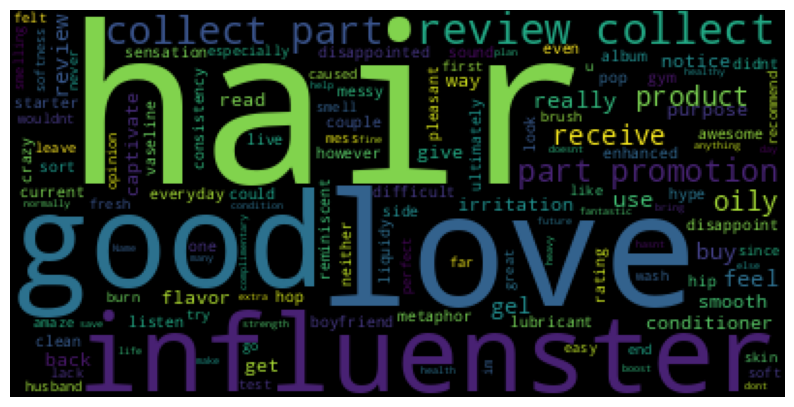

In [49]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
wordcloud = WordCloud(stopwords=stop_words,max_words=200).generate(str(df_clean.reviews_text_cleaned))

print(wordcloud)
plt.figure(figsize= (10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

(array([1.0622e+04, 1.2187e+04, 3.9170e+03, 1.5600e+03, 7.5600e+02,
        3.1200e+02, 2.3100e+02, 1.1900e+02, 6.7000e+01, 4.2000e+01,
        3.5000e+01, 3.4000e+01, 1.2000e+01, 3.0000e+00, 1.0000e+01,
        3.0000e+00, 4.0000e+00, 2.0000e+00, 3.0000e+00, 5.0000e+00,
        5.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([3.00000e+00, 7.68400e+01, 1.50680e+02, 2.24520e+02, 2.98360e+02,
        3.72200e+02, 4.46040e+02, 5.19880e+02, 5.93720e+02, 6.67560e+02,
        7.41400e+02, 8.15240e+02, 8.89080e+02, 9.62920e+02, 1.03676e+03,
        1.11060e+03, 1.18444e+03, 1.25828e+03, 1.33212e+03, 1.40596e+03,
        1.47980e+03, 1.553

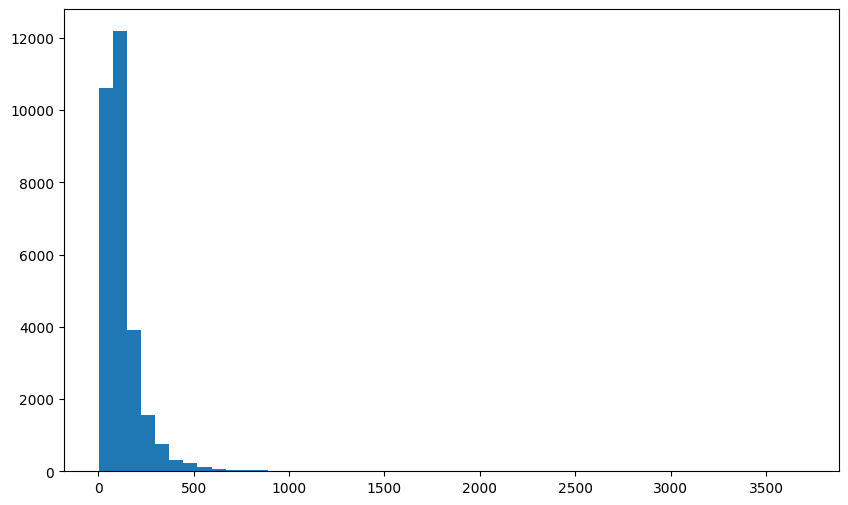

In [50]:
#visualise the data according to the 'Review Text' character length
plt.figure(figsize=(10,6))
reviews_lens = [len(d) for d in df_clean.reviews_text_cleaned]
plt.hist(reviews_lens, bins = 50)

In [51]:
def getMostCommonWords(reviews, n_most_common):
    # flatten review column into a list of words, and set each to lowercase
    flattened_reviews = [word for review in reviews for word in \
                         review.lower().split()]


    # remove punctuation from reviews
    flattened_reviews = [''.join(char for char in review if \
                                 char not in string.punctuation) for \
                         review in flattened_reviews]


    # remove any empty strings that were created by this process
    flattened_reviews = [review for review in flattened_reviews if review]

    return Counter(flattened_reviews).most_common(n_most_common)

In [52]:
pos_reviews = df_clean[df_clean['user_sentiment']==1]
getMostCommonWords(pos_reviews['reviews_text_cleaned'],10)

[('great', 14397),
 ('love', 12429),
 ('use', 11725),
 ('product', 10805),
 ('movie', 9855),
 ('review', 8881),
 ('part', 8728),
 ('promotion', 8374),
 ('wipe', 8189),
 ('clean', 8075)]

In [53]:
neg_reviews = df_clean[df_clean['user_sentiment']==0]
getMostCommonWords(neg_reviews['reviews_text_cleaned'],10)

[('product', 1934),
 ('use', 1794),
 ('hair', 1575),
 ('formula', 1439),
 ('new', 1261),
 ('like', 1090),
 ('old', 1078),
 ('good', 1075),
 ('movie', 1033),
 ('gel', 876)]

In [54]:
#function to collect the n-gram frequency of words
def get_top_n_ngram( corpus, n_gram_range ,n=None):
    vec = CountVectorizer(ngram_range=(n_gram_range, n_gram_range), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0)
    print("--1",sum_words)
    for word, idx in vec.vocabulary_.items():
        #print(word)
        #print(idx)
        break
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    #print("-31",words_freq)
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [55]:
#Print the top 10 words in the bigram frequency
common_words = get_top_n_ngram(pos_reviews['reviews_text_cleaned'], 2, 10)
pd.DataFrame(common_words)

--1 [[1 1 1 ... 1 1 1]]


,0,1
0,review collect,7920
1,collect promotion,7920
2,clorox wipe,2803
3,great product,1944
4,great movie,1739
5,easy use,1554
6,love clorox,1223
7,love product,1137
8,use clorox,1088
9,good movie,922


In [56]:
#Print the top 10 words in the bigram frequency
common_words = get_top_n_ngram(neg_reviews['reviews_text_cleaned'], 2, 10)
pd.DataFrame(common_words)

--1 [[1 1 1 ... 1 1 2]]


,0,1
0,new formula,520
1,old formula,515
2,bring old,369
3,review collect,346
4,collect promotion,346
5,exxtra gel,205
6,use product,183
7,make hair,157
8,shampoo conditioner,147
9,gel year,127


--1 [[1 1 1 ... 1 1 2]]


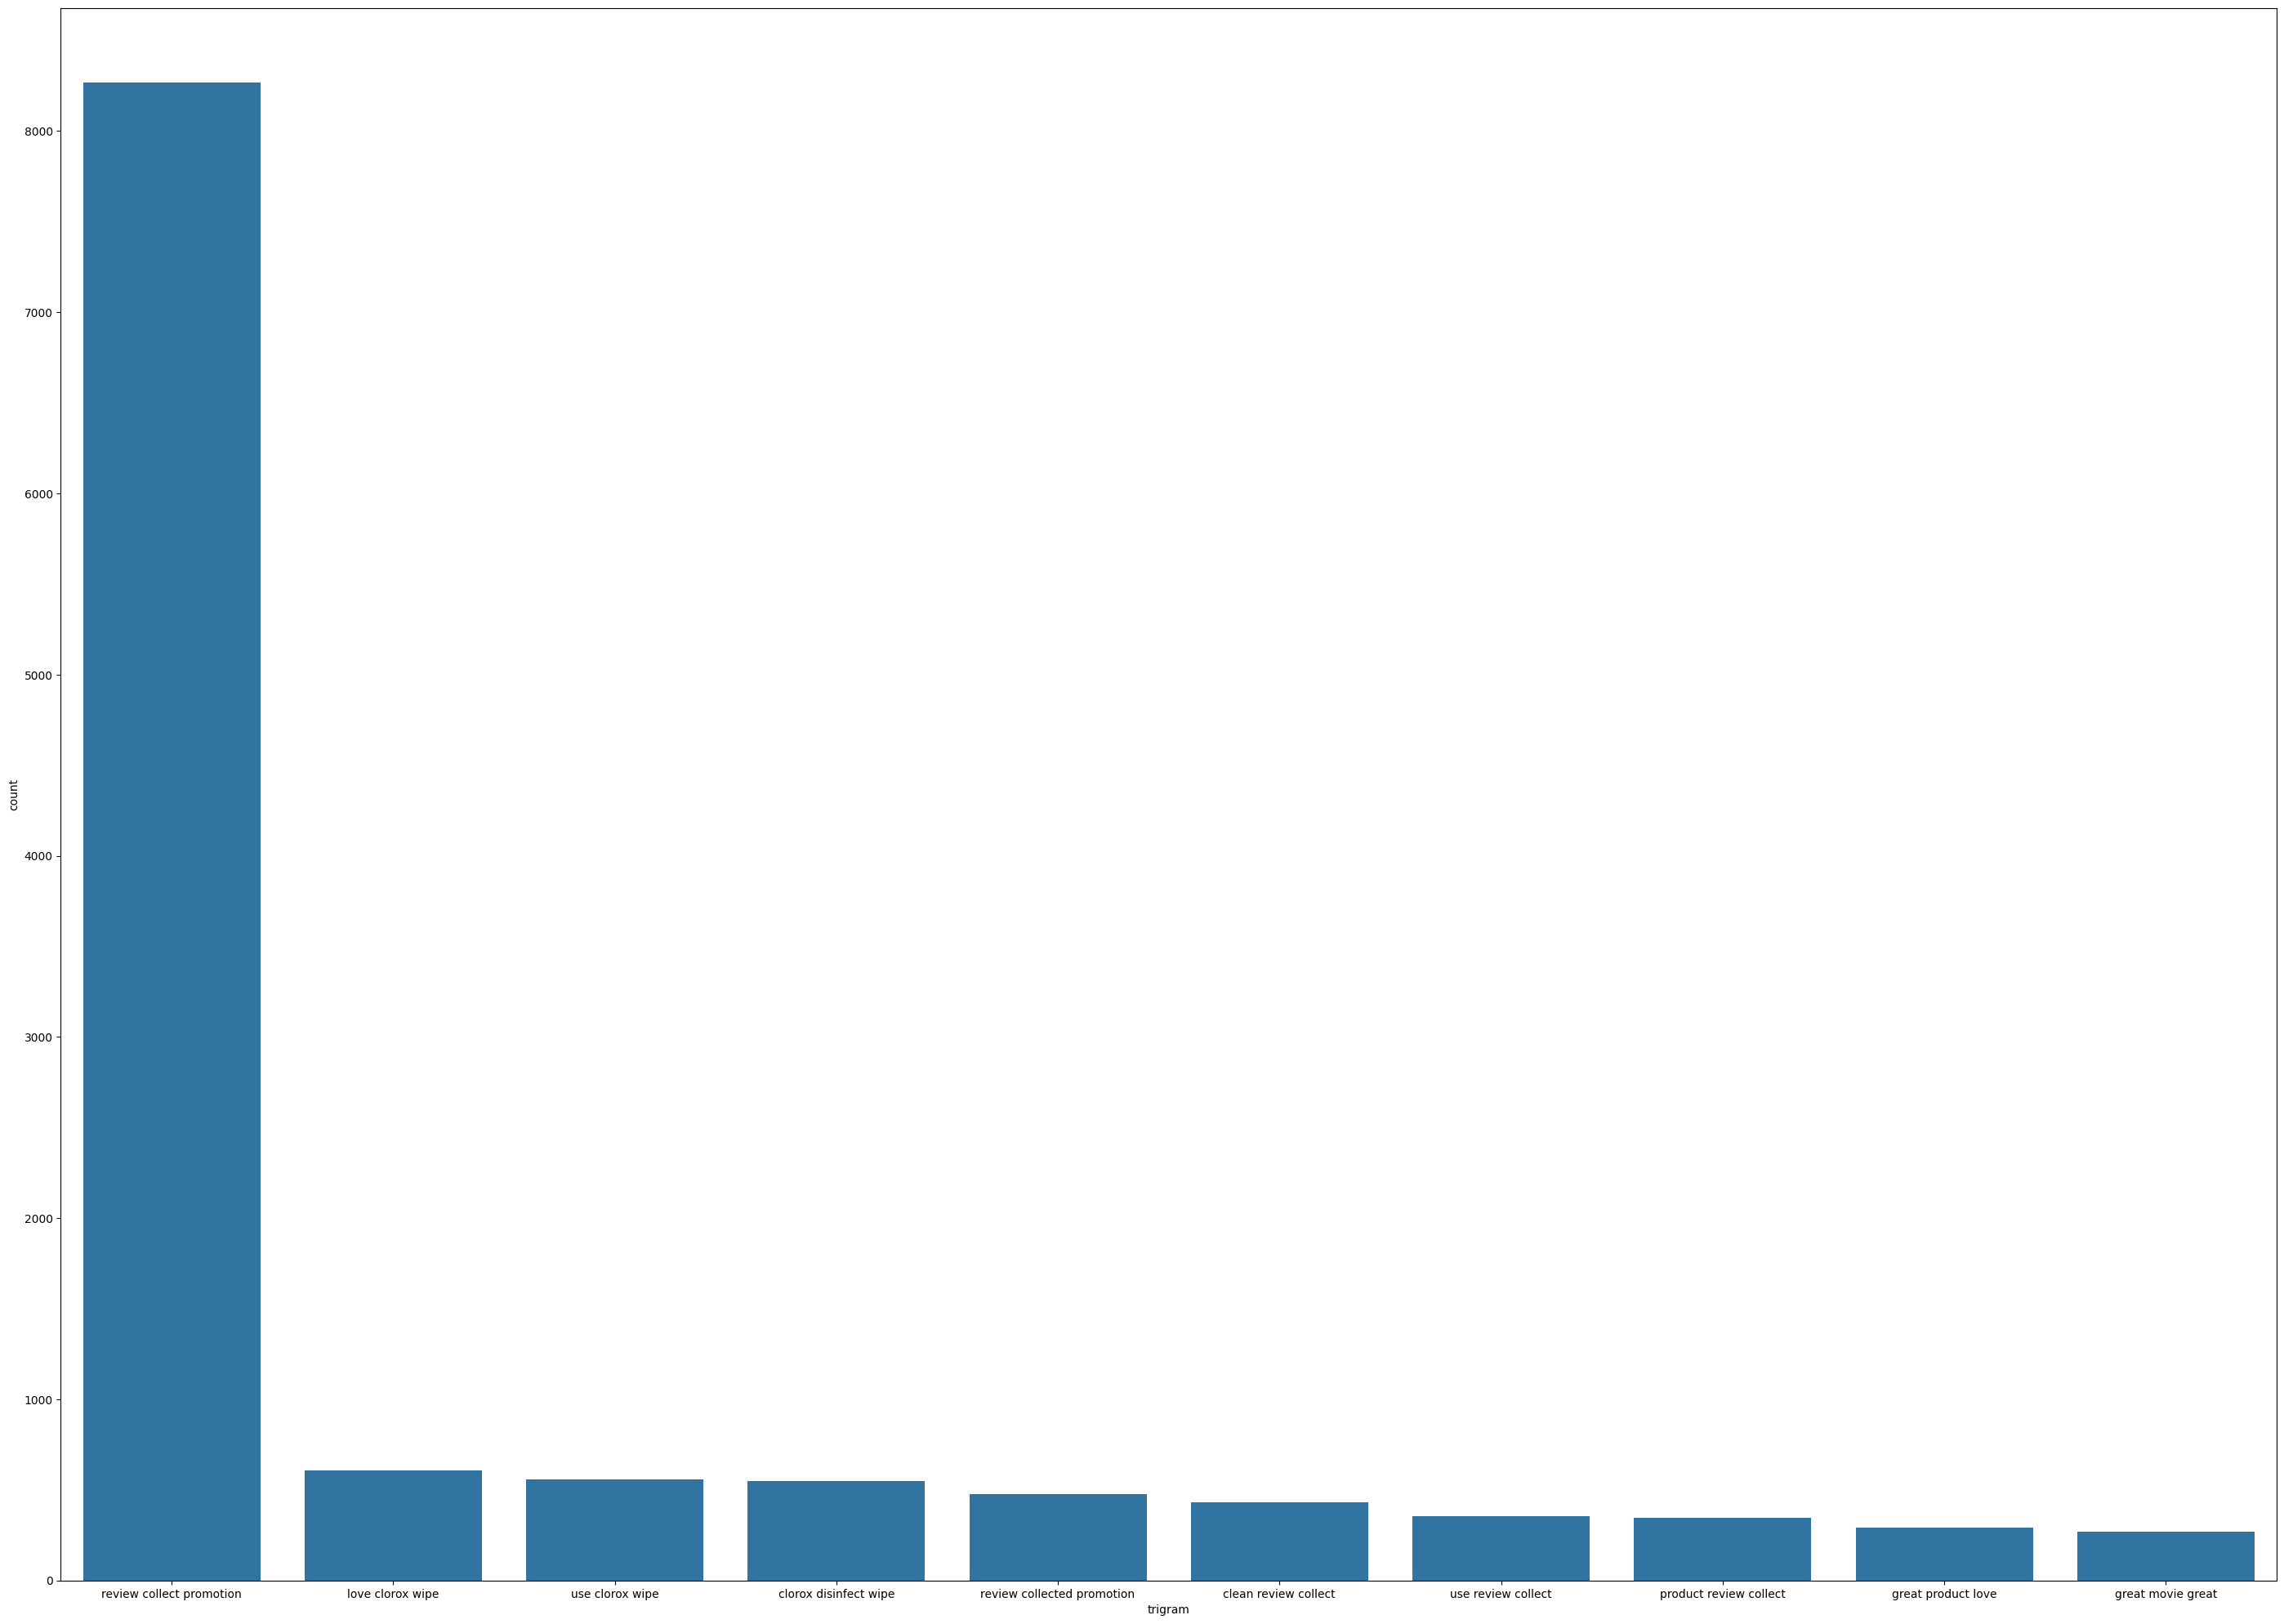

In [57]:
#logic to find the top 10 trigram frequency among the reviews_text in the cleaned datafram(df_clean).
common_words = get_top_n_ngram(df_clean.reviews_text_cleaned, 3, 10)
df3 = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
plt.figure(figsize=[35,25])
fig = sns.barplot(x=df3['trigram'], y=df3['count'])

In [58]:
X = df_clean['reviews_text_cleaned']
y = df_clean['user_sentiment']

In [59]:
df_clean.head()

,id,name,reviews_full_text,user_sentiment,reviews_text,reviews_text_cleaned
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),Just Awesome. i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,1,just awesome i love this album its very good more to the hip hop side than her current pop sound so hype i listen to this everyday at the gym i give it rating all the way her metaphors are just crazy,awesome love album good hip hop side current pop sound hype listen everyday gym give rating way metaphor crazy
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good. Good flavor. This review was collected as part of a promotion.,1,good good flavor this review was collected as part of a promotion,good good flavor review collect part promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good. Good flavor.,1,good good flavor,good good flavor
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,"Disappointed. I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation...",0,disappointed i read through the reviews on here before looking in to buying one of the couples lubricants and was ultimately disappointed that it didnt even live up to the reviews i had read for starters neither my boyfriend nor i could notice any sort of enhanced or captivating sensation what w...,disappoint read review look buy one couple lubricant ultimately disappointed didnt even live review read starter neither boyfriend could notice sort enhanced captivate sensation notice however messy consistency reminiscent liquidy vaseline difficult clean pleasant especially since lack captivate...
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,Irritation. My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,0,irritation my husband bought this gel for us the gel caused irritation and it felt like it was burning my skin i wouldnt recommend this gel,irritation husband buy gel u gel caused irritation felt like burn skin wouldnt recommend gel


### 5. Data Augmentation: Enriching Negative Sentiment Samples Using Synonym Replacement

Filter the Original Dataset for Negative Sentiment Extract all rows labeled with negative sentiment from the original dataset. This subset serves as the foundation for generating augmented samples to help balance the training data.

Define a Synonym Replacement Function Using WordNet Implement a function that takes a sentence (sent) and replaces up to n_sr words with randomly selected synonyms using WordNet (via the NLTK library). The objective is to preserve semantic meaning while introducing lexical variation, thereby improving the model’s ability to generalize.

Generate Augmented Sentences Apply the synonym replacement function to each cleaned negative sentence.

Merge Original and Augmented Sentiment Data Concatenate the original cleaned dataset with the augmented negative samples. This results in a more diverse and balanced training set, enhancing classifier robustness—especially for underrepresented negative classes.

Why This Matters:

Data augmentation reduces class imbalance, improves generalization, and boosts performance on real-world, noisy text inputs—all of which are key for building a reliable sentiment analysis model.


In [60]:
def synonym_replacement(sent, n_sr=2):
    words = sent.split()
    if len(words) == 0:
        return sent
    new = words.copy()
    idxs = list(range(len(words)))
    random.shuffle(idxs)
    rep = 0
    for i in idxs:
        syns = set(l.name().replace('_',' ') for syn in wordnet.synsets(words[i]) for l in syn.lemmas())
        syns.discard(words[i])
        if syns:
            new[i] = random.choice(list(syns))
            rep += 1
        if rep >= n_sr:
            break
    return ' '.join(new)

In [61]:
#import random
#neg_sentiment_reviews = df_clean[df_clean["user_sentiment"] == 0].copy()
#neg_sentiment_reviews['reviews_text_cleaned'] = neg_sentiment_reviews['reviews_text_cleaned'].apply(lambda x: synonym_replacement(x, n_sr=2))
#df_clean = pd.concat([df_clean[df_clean["user_sentiment"] == 1], neg_sentiment_reviews])

### 6. Feature Extraction

In [62]:
no_of_classes= len(pd.Series(y).value_counts())

In [63]:
#Distribution of the target variable data in terms of proportions.
for i in range(0,no_of_classes):
    print("Percent of {0}s: ".format(i), round(100*pd.Series(y).value_counts()[i]/pd.Series(y).value_counts().sum(),2), "%")

Percent of 0s:  10.47 %
Percent of 1s:  89.53 %


To Vectorize the data, using TF-IDF vectorizer method to dervie the features from the textual data

As it's clearly a class-imbalance between positive and negative, let's do SMOTE oversampling technique before modelling

In [64]:
#using TF-IDF vectorizer using the parameters to get 650 features.
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=650, max_df=0.9, min_df=7, binary=True,
                                   ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(df_clean['reviews_text_cleaned'])

y= df_clean['user_sentiment']

In [65]:
print(tfidf_vectorizer.get_feature_names_out())

['able' 'absolutely' 'absolutely love' 'act' 'action' 'action movie'
 'actor' 'actually' 'add' 'age' 'ago' 'amaze' 'amazing' 'apply' 'area'
 'ask' 'available' 'away' 'awesome' 'awesome movie' 'awesome product'
 'awful' 'baby' 'bad' 'bag' 'bathroom' 'bathroom kitchen' 'beautiful'
 'bee' 'begin' 'believe' 'best' 'best buy' 'best product' 'big' 'bit'
 'black' 'bleach' 'blu' 'blu ray' 'bluray' 'body' 'bottle' 'box' 'boy'
 'brand' 'break' 'bring' 'bring cocoa' 'bring old' 'brown' 'burt'
 'burt bee' 'buy' 'canister' 'car' 'care' 'carpet' 'carry' 'cast' 'cd'
 'chair' 'change' 'character' 'cheap' 'child' 'chip' 'classic' 'classroom'
 'clay' 'clean' 'clean bathroom' 'clean disinfect' 'clean easy'
 'clean fresh' 'clean great' 'clean kitchen' 'clean love' 'clean mess'
 'clean product' 'clean review' 'clean smell' 'clean ups' 'clean use'
 'clean wipe' 'cleaner' 'cleaning' 'cleanup' 'clear' 'clorox'
 'clorox disinfect' 'clorox love' 'clorox product' 'clorox wipe' 'close'
 'cocoa' 'cold' 'collect' '

In [66]:
# splitting into test and train
from sklearn.model_selection  import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, y, random_state=42, test_size=0.25)

### Handling Class imbalance

To mitigate class imbalance in the training data, we employ Random Oversampling, a technique that increases the representation of the minority class by duplicating its samples. This ensures a more balanced dataset, which is crucial for training robust classifiers.

- We instantiate RandomOverSampler from the imblearn library, specifying a fixed random_state to maintain reproducibility.

- The fit_resample() method is applied exclusively to the training set (X_train, y_train). This is a critical step to prevent data leakage, which could compromise model evaluation.

- The method randomly replicates samples from the minority class until both classes are equally represented.

In [67]:
counter = Counter(y_train)
print('Before',counter)

# RandomOverSampler = RandomOverSampler(random_state=42) # considered RandomOverSampler over SMOTE but the performance is less
sm = SMOTE()

# transform the dataset
X_train, y_train = sm.fit_resample(X_train, y_train)

counter = Counter(y_train)
print('After',counter)

Before Counter({1: 20087, 0: 2365})
After Counter({1: 20087, 0: 20087})


### 7. Model Building

We train several classifiers (Logistic Regression, Random Forest, XGBoost, Naive Bayes), optionally using grid‑search on key hyperparameters (e.g. n_estimators for RF). This lets us compare their out‑of‑the‑box performance and pick the most promising one. Each model is trained using the same training data for fair comparison.

In [68]:
import time
from sklearn import metrics
import pickle

In [69]:
class ModelBuilder:
    def __init__(self, model, x_train, x_test, y_train, y_test):
        self.model = model
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test


    def train_model(self):
        self.model.fit(self.x_train,self.y_train)
        return self.model.predict(self.x_test)

    def evaluate_model(self, y_pred_class):
        print("\n")
        print("*"*30)
        self.result_metrics = self.evaluate_metrics(y_pred_class)
        print("*"*30)
        print("\n")

        self.classification_report(y_pred_class)
        print("*"*30)
        print("\n")
        self.confusion_matrix(y_pred_class)

        print("*"*30)
        print("\n")

        from sklearn.metrics import RocCurveDisplay
        RocCurveDisplay.from_estimator(self.model, self.x_test, self.y_test)
        plt.show()


        return self.result_metrics

    def evaluate_metrics(self, y_pred_class):
        result_metrics = []
        accuracy = metrics.accuracy_score(self.y_test, y_pred_class)
        precision = metrics.precision_score(self.y_test, y_pred_class)
        recall = metrics.recall_score(self.y_test, y_pred_class)
        f1score = metrics.f1_score(self.y_test, y_pred_class)
        y_pred_prob = self.model.predict_proba(self.x_test)[:,1]
        roc_auc = metrics.roc_auc_score(self.y_test, y_pred_prob)

        print(f"Accuracy is : {accuracy*100:.1f}%")
        print(f"Precision is : {precision*100:.1f}%")
        print(f"Recall is : {recall*100:.1f}%")
        print(f"F1 Score is : {f1score*100:.1f}%")
        print(f"Roc-Auc Score is:{roc_auc*100:.1f}%")

        result_metrics.append(accuracy)
        result_metrics.append(precision)
        result_metrics.append(recall)
        result_metrics.append(f1score)
        result_metrics.append(roc_auc)
        return result_metrics

    def confusion_matrix(self, y_pred_class):
        confusion_matrix = metrics.confusion_matrix(self.y_test, y_pred_class)
        self.plot_confusion_matrix(confusion_matrix,[0,1])


    def plot_confusion_matrix(self, data, labels):
        sns.set(color_codes=True)
        plt.title("Confusion Matrix")
        ax = sns.heatmap(data/np.sum(data), annot=True, cmap="Blues", fmt=".2%")

        ax.set_xticklabels(labels)
        ax.set_yticklabels(labels)

        ax.set(ylabel="True Values", xlabel="Predicted Values")
        plt.show()

    def classification_report(self, y_pred_class):
        print(metrics.classification_report(self.y_test, y_pred_class))

### Logistic Regression

In [70]:
# Build the Logistic Regression model.
%time
logreg_ci = LogisticRegression(random_state=42, max_iter=100,solver='liblinear', class_weight="balanced")
params = {'C':[0.01,0.1,1,10]}
grid_search_lr = GridSearchCV(estimator=logreg_ci, param_grid=params, cv=5, n_jobs=-1, verbose=1, scoring="f1")
grid_search_lr.fit(X_train, y_train)
lr_best = grid_search_lr.best_estimator_

lr_ci_modebuilder = ModelBuilder(lr_best, X_train, X_test, y_train, y_test)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
Fitting 5 folds for each of 4 candidates, totalling 20 fits




******************************
Accuracy is : 88.3%
Precision is : 96.6%
Recall is : 90.1%
F1 Score is : 93.3%
Roc-Auc Score is:89.7%
******************************


              precision    recall  f1-score   support

           0       0.46      0.73      0.56       770
           1       0.97      0.90      0.93      6714

    accuracy                           0.88      7484
   macro avg       0.71      0.81      0.75      7484
weighted avg       0.91      0.88      0.89      7484

******************************




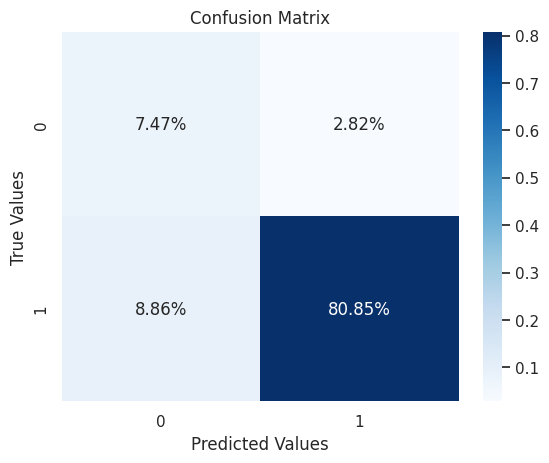

******************************




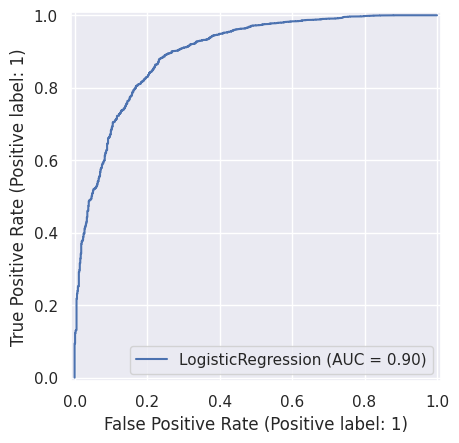

In [71]:
# Train and Predict the Test Labels
y_pred_class  = lr_ci_modebuilder.train_model()
lr_metrics = lr_ci_modebuilder.evaluate_model(y_pred_class)

F1 Score looks to be good, though the individual class(0) is lesser. let;s try with other alogithms if we can increase the overall F1 and for the individual classes

### Naive Bayes

In [72]:
# training the NB model and making predictions
from sklearn.naive_bayes import MultinomialNB

In [73]:
mnb = MultinomialNB()
params = {'alpha':[0.5,1.0,1.5]}
grid_search_mnb = GridSearchCV(estimator=mnb, param_grid=params, cv=5, n_jobs=-1, verbose=1, scoring="f1")
grid_search_mnb.fit(X_train, y_train)
mnb_best = grid_search_mnb.best_estimator_
mnb_modebuilder = ModelBuilder(mnb_best, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits




******************************
Accuracy is : 81.1%
Precision is : 97.5%
Recall is : 81.0%
F1 Score is : 88.5%
Roc-Auc Score is:89.6%
******************************


              precision    recall  f1-score   support

           0       0.33      0.82      0.47       770
           1       0.98      0.81      0.89      6714

    accuracy                           0.81      7484
   macro avg       0.65      0.82      0.68      7484
weighted avg       0.91      0.81      0.84      7484

******************************




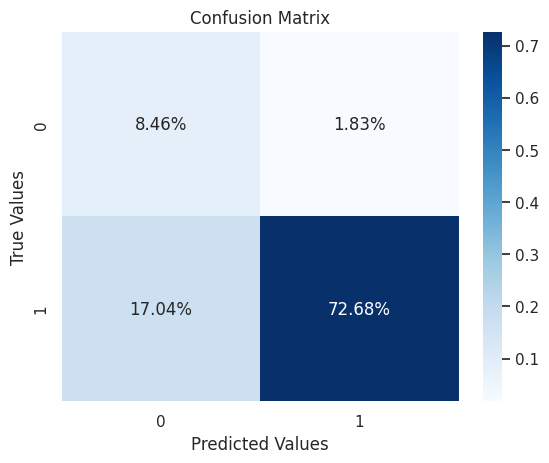

******************************




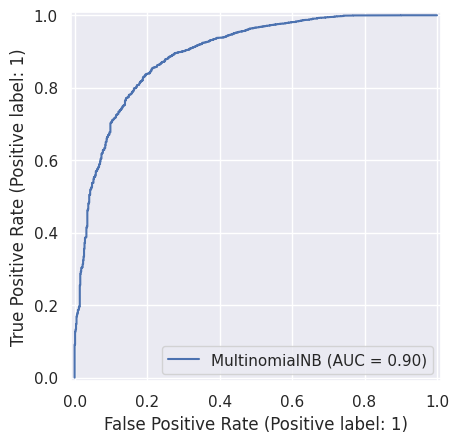

In [74]:
# Train and Predict the Test Labels
y_pred_class  = mnb_modebuilder.train_model()
nb_metrics = mnb_modebuilder.evaluate_model(y_pred_class)

### Random Forrest

In [75]:
rf = RandomForestClassifier(oob_score=True, random_state=42, criterion="gini")

In [76]:
params = {
    'max_depth': [2,3,5,10],
    'min_samples_leaf': [5,10,20,50],
    'n_estimators': [10, 25, 50, 100]
}

In [77]:
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 5,
                           n_jobs=-1, verbose=1, scoring="f1")

In [78]:
%time
grid_search.fit(X_train, y_train)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs
Fitting 5 folds for each of 64 candidates, totalling 320 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10],
                         'min_samples_leaf': [5, 10, 20, 50],
                         'n_estimators': [10, 25, 50, 100]},
             scoring='f1', verbose=1)

In [79]:
rf_best = grid_search.best_estimator_
rf_modebuilder = ModelBuilder(rf_best, X_train, X_test, y_train, y_test)



******************************
Accuracy is : 79.9%
Precision is : 96.3%
Recall is : 80.8%
F1 Score is : 87.8%
Roc-Auc Score is:85.9%
******************************


              precision    recall  f1-score   support

           0       0.30      0.73      0.43       770
           1       0.96      0.81      0.88      6714

    accuracy                           0.80      7484
   macro avg       0.63      0.77      0.65      7484
weighted avg       0.89      0.80      0.83      7484

******************************




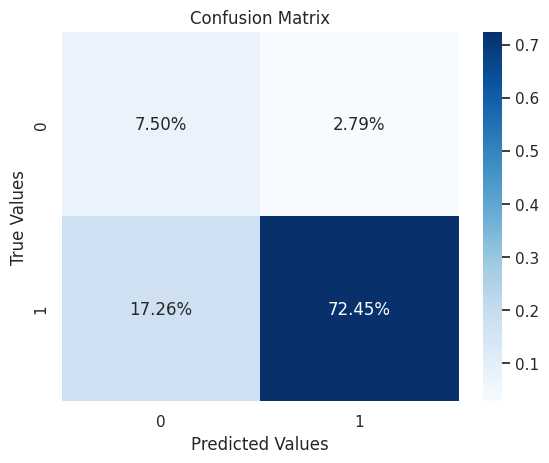

******************************




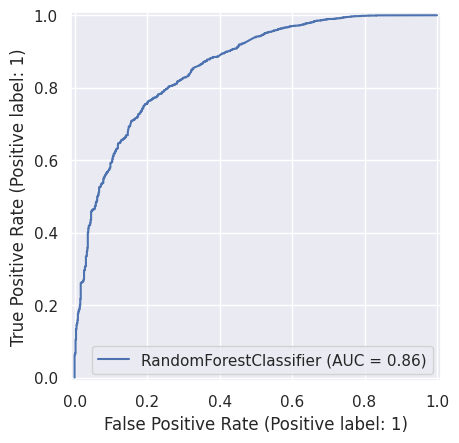

In [80]:
# Train and Predict the Test Labels
y_pred_class  = rf_modebuilder.train_model()
rf_metrics = rf_modebuilder.evaluate_model(y_pred_class)

### XGBoost Classifier

In [81]:
import xgboost as xgb

In [82]:
xgclf = xgb.XGBClassifier(learning_rate=0.15, max_depth=10, random_state=42) #based on the tuned parameters
xg_modebuilder = ModelBuilder(xgclf, X_train, X_test, y_train, y_test)



******************************
Accuracy is : 90.6%
Precision is : 95.8%
Recall is : 93.6%
F1 Score is : 94.7%
Roc-Auc Score is:90.7%
******************************


              precision    recall  f1-score   support

           0       0.53      0.64      0.58       770
           1       0.96      0.94      0.95      6714

    accuracy                           0.91      7484
   macro avg       0.75      0.79      0.76      7484
weighted avg       0.91      0.91      0.91      7484

******************************




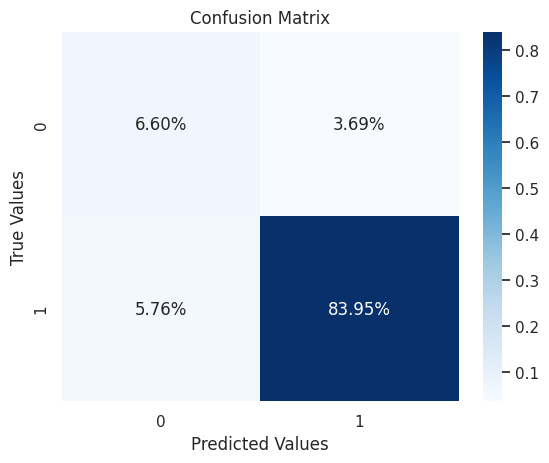

******************************




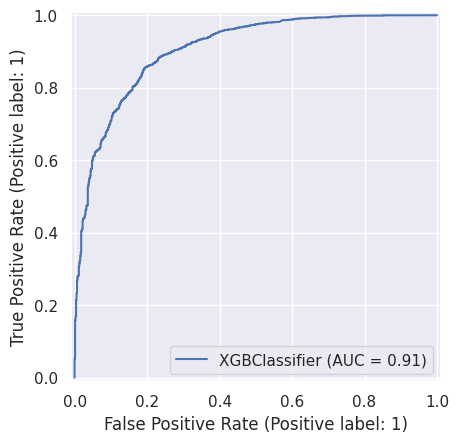

In [83]:
# Train and Predict the Test Labels
y_pred_class  = xg_modebuilder.train_model()
xg_metrics = xg_modebuilder.evaluate_model(y_pred_class)

### LSTM Classifier

### Model Inference

In [84]:
xg_metrics

[0.9055318011758418,
 0.9579204146973624,
 0.9358057789693178,
 0.9467339712197694,
 np.float64(0.9073908367474052)]

In [85]:
# Creating a table which contain all the metrics

metrics_table = {'Metric': ['Accuracy','Precision','Recall',
                       'F1Score','Auc Score'],
        'Logistic Regression': lr_metrics,
        'Naive Bayes': nb_metrics,
         'Random Forrest': rf_metrics,
        'XG Boost': xg_metrics
        }

df_metrics = pd.DataFrame(metrics_table ,columns = ['Metric', 'Logistic Regression', 'Naive Bayes','Random Forrest',
                                                    'XG Boost'] )

df_metrics


,Metric,Logistic Regression,Naive Bayes,Random Forrest,XG Boost
0,Accuracy,0.88,0.81,0.80,0.91
1,Precision,0.97,0.98,0.96,0.96
2,Recall,0.90,0.81,0.81,0.94
3,F1Score,0.93,0.89,0.88,0.95
4,Auc Score,0.90,0.90,0.86,0.91


Comparing the above models on the metrics, XG Boost looks to be a better model, saving the XG Boost model as a pickle file for later use

#### Saving the model

In [86]:
def save_object(obj, filename):
    filename = "/content/gdrive/MyDrive/capstone/"+filename+'.pkl'
    pickle.dump(obj, open(filename, 'wb'))

In [87]:
save_object(logreg_ci, 'sentiment-classification-logreg-model')

In [88]:
save_object(tfidf_vectorizer, 'tfidf-vectorizer')

In [89]:
save_object(df_clean, 'cleaned-data')

## Recommendation System

Different Approaches to develop Recommendation System -

Here we are going to try with 2 of the Colloboarative filtering techniques:
    - User-User Based Approach
    - Item-Item Based Approach

In [90]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29936 entries, 0 to 29999
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    29936 non-null  object
 1   brand                 29936 non-null  object
 2   categories            29936 non-null  object
 3   manufacturer          29795 non-null  object
 4   name                  29936 non-null  object
 5   reviews_date          29896 non-null  object
 6   reviews_didPurchase   15931 non-null  object
 7   reviews_doRecommend   27395 non-null  object
 8   reviews_rating        29936 non-null  int64 
 9   reviews_text          29936 non-null  object
 10  reviews_title         29936 non-null  object
 11  reviews_userCity      1900 non-null   object
 12  reviews_userProvince  166 non-null    object
 13  reviews_username      29936 non-null  object
 14  user_sentiment        29936 non-null  int64 
 15  reviews_full_text     29936 non-null  obj

In [91]:
df_recommendation = df_reviews[["id", "name", "reviews_rating", "reviews_username"]]
calcMissingRowCount(df_recommendation)

,0
id,0
name,0
reviews_rating,0
reviews_username,0


In [92]:
#splitting the train and test
train, test = train_test_split(df_recommendation, test_size=0.25, random_state=42)

In [93]:
print(train.shape)
print(test.shape)

(22452, 4)
(7484, 4)


In [94]:
product_column = "id"
user_column = "reviews_username"
value_column = "reviews_rating"

In [95]:
# Pivot the train ratings' dataset into matrix format in which columns are product names and the rows are user names.
df_pivot = pd.pivot_table(train,index=user_column, columns = product_column, values = value_column).fillna(0)
df_pivot.head(10)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6_VI1cnluZ0-Z4do,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7JTHilAPnD_xQ_Cl,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,...,AVpfKa3uilAPnD_xWSGx,AVpfKb8k1cnluZ0-fQdA,AVpfKhuv1cnluZ0-fSVr,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfP-rELJeJML435jEN,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfa1joLJeJML4385hb,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfddjcLJeJML439loo,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfh1gsilAPnD_xdX_S,AVpfhpNkilAPnD_xdUZz,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVp

### Creating dummy train and test

In [96]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()
item_test = test.copy()

In [97]:
dummy_train.head()

,id,name,reviews_rating,reviews_username
27954,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),5,silvahalo
3375,AVpe5s3RLJeJML43x4eA,Pantene Pro-V Expert Collection Age Defy Conditioner,4,stacberg
20192,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,5,erwerw
457,AV1l8zRZvKc47QAVhnAv,Olay Regenerist Deep Hydration Regenerating Cream,5,olay53
19060,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,5,nicelady


In [98]:
# The products not rated by user is marked as 1 for prediction.
dummy_train[value_column] = dummy_train[value_column].apply(lambda x: 0 if x>=1 else 1)

In [99]:
# Pivot the train ratings' dataset into matrix format in which columns are product names and the rows are user names.
dummy_train = pd.pivot_table(dummy_train,index=user_column, columns = product_column, values = value_column).fillna(1)
dummy_train.head(10)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6_VI1cnluZ0-Z4do,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7JTHilAPnD_xQ_Cl,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,...,AVpfKa3uilAPnD_xWSGx,AVpfKb8k1cnluZ0-fQdA,AVpfKhuv1cnluZ0-fSVr,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfP-rELJeJML435jEN,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfa1joLJeJML4385hb,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfddjcLJeJML439loo,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfh1gsilAPnD_xdX_S,AVpfhpNkilAPnD_xdUZz,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVp

### User similarity matrix

In [100]:
df_pivot.index.nunique()

19427

In [101]:
from sklearn.metrics.pairwise import pairwise_distances, cosine_similarity

In [102]:
#using cosine_similarity function to compute the distance.
user_correlation = cosine_similarity(df_pivot)
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)
print(user_correlation.shape)

[[1.        0.        0.        ... 0.        0.9486833 0.       ]
 [0.        1.        1.        ... 0.        0.        0.       ]
 [0.        1.        1.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 1.        0.        1.       ]
 [0.9486833 0.        0.        ... 0.        1.        0.       ]
 [0.        0.        0.        ... 1.        0.        1.       ]]
(19427, 19427)


### Prediction User-User

In [103]:
#filtering out the user_correlation that are negatively correlated
user_correlation[user_correlation<0]=0
user_correlation

array([[1.       , 0.       , 0.       , ..., 0.       , 0.9486833,
        0.       ],
       [0.       , 1.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 1.       , 1.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ],
       [0.9486833, 0.       , 0.       , ..., 0.       , 1.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 1.       , 0.       ,
        1.       ]])

In [104]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 1.20913332, ..., 2.9103958 , 0.        ,
        0.54410719],
       [0.        , 0.        , 3.12347524, ..., 3.00158035, 0.        ,
        0.        ],
       [0.        , 0.        , 3.12347524, ..., 3.00158035, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        2.88675135],
       [0.        , 0.        , 0.        , ..., 1.64034869, 0.        ,
        0.57353933],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        2.88675135]])

In [105]:
#since we are interested in products that are not rated by the user, we multiply with dummy train to make it zero
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6_VI1cnluZ0-Z4do,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7JTHilAPnD_xQ_Cl,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,...,AVpfKa3uilAPnD_xWSGx,AVpfKb8k1cnluZ0-fQdA,AVpfKhuv1cnluZ0-fSVr,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfP-rELJeJML435jEN,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfa1joLJeJML4385hb,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfddjcLJeJML439loo,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfh1gsilAPnD_xdX_S,AVpfhpNkilAPnD_xdUZz,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVp

### Find 20 recommendation for the user

In [106]:
user_input = "08dallas"
print(user_input)

08dallas


In [107]:
recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
recommendations

,08dallas
id,
AVpfPaoqLJeJML435Xk9,24.41
AVpfRTh1ilAPnD_xYic2,20.73
AVpf3VOfilAPnD_xjpun,8.48
AVpe41TqilAPnD_xQH3d,6.58
AVpf0eb2LJeJML43EVSt,5.06
AVpfBrUZilAPnD_xTUly,4.57
AVpfJP1C1cnluZ0-e3Xy,3.68
AV1l8zRZvKc47QAVhnAv,3.54
AVpf5olc1cnluZ0-tPrO,3.40


In [108]:
#display the top 20 product id, name and similarity_score
final_recommendations = pd.DataFrame({'product_id': recommendations.index, 'similarity_score' : recommendations})
final_recommendations.reset_index(drop=True)
pd.merge(final_recommendations, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

,id,name,similarity_score
0,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,24.41
2464,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),20.73
3315,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,8.48
9689,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),6.58
10262,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),5.06
10899,AVpfBrUZilAPnD_xTUly,"Coty Airspun Face Powder, Translucent Extra Coverage",4.57
11022,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,3.68
12585,AV1l8zRZvKc47QAVhnAv,Olay Regenerist Deep Hydration Regenerating Cream,3.54
13067,AVpf5olc1cnluZ0-tPrO,Chester's Cheese Flavored Puffcorn Snacks,3.40
13196,AVpf7I3i1cnluZ0-tnL6,Mrs. Meyer's174 Lemon Verbena Laundry Scent Booster - 18oz,2.89


### Evaluation User-User

In [109]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(1795, 4)

In [110]:
common.head()

,id,name,reviews_rating,reviews_username
12875,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,jessica
22577,AVpfOmKwLJeJML435GM7,Clear Scalp & Hair Therapy Total Care Nourishing Shampoo,4,at527
21657,AVpfm8yiLJeJML43AYyu,Nexxus Exxtra Gel Style Creation Sculptor,1,romance318
23320,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,3,countprice
21505,AVpfm8yiLJeJML43AYyu,Nexxus Exxtra Gel Style Creation Sculptor,1,farbar


In [111]:
# convert into the user-movie matrix.
common_user_based_matrix = pd.pivot_table(common,index=user_column, columns = product_column, values = value_column)
common_user_based_matrix.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf7fFbilAPnD_xkrmW,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfBwE4ilAPnD_xTWO1,AVpfC3KoLJeJML431KRR,AVpfCuzrilAPnD_xTroT,AVpfD9xTLJeJML431ig2,AVpfDI3xilAPnD_xTz-k,AVpfE7puilAPnD_xUcCW,AVpfEqruilAPnD_xUWDr,AVpfGRUHilAPnD_xU5nU,AVpfGuDrLJeJML432fDz,AVpfH2Rx1cnluZ0-eYtu,AVpfHf4wLJeJML432vqK,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKb8k1cnluZ0-fQdA,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbkyr1cnluZ0-kozI,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfiUrfLJeJML43-9nY,AVpfk4y7ilAPnD_xeTgd,AVpfkak01cnluZ0-nJj6,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmjXGLJeJML43AQ5_,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [112]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,19327,19328,19329,19330,19331,19332,19333,19334,19335,19336,19337,19338,19339,19340,19341,19342,19343,19344,19345,19346,19347,19348,19349,19350,19351,19352,19353,19354,19355,19356,19357,19358,19359,19360,19361,19362,19363,19364,19365,19366,19367,19368,19369,19370,19371,19372,19373,19374,19375,19376,19377,19378,19379,19380,19381,19382,19383,19384,19385,19386,19387,19388,19389,19390,19391,19392,19393,19394,19395,19396,19397,19398,19399,19400,19401,19402,19403,19404,19405,19406,19407,19408,19409,19410,19411,19412,19413,19414,19415,19416,19417,19418,19419,19420,19421,19422,19423,19424,19425,19426
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.0,0.0,0.0,0.21,0.0,0.0,0.0,0.95,0.32,0.0,0.0,0.0,0.0,0.32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.0,0.95,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.0,0.32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.84,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.32,0.0,0.95,0.0,0.32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.0
1,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.53,0.0,0.0,0.0,0.00,0.00,1.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.51,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.71,1.0,0.0,0.0,0.00,0.0,1.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.53,0.0,0.0,0.0,0.00,0.00,1.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.51,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.71,1.0,0.0,0.0,0.00,0.0,1.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
3,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.53,0.0,0.0,0.0,0.00,0.00,1.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.51,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0

In [113]:
user_correlation_df[user_column] = df_pivot.index
user_correlation_df.set_index(user_column,inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,19327,19328,19329,19330,19331,19332,19333,19334,19335,19336,19337,19338,19339,19340,19341,19342,19343,19344,19345,19346,19347,19348,19349,19350,19351,19352,19353,19354,19355,19356,19357,19358,19359,19360,19361,19362,19363,19364,19365,19366,19367,19368,19369,19370,19371,19372,19373,19374,19375,19376,19377,19378,19379,19380,19381,19382,19383,19384,19385,19386,19387,19388,19389,19390,19391,19392,19393,19394,19395,19396,19397,19398,19399,19400,19401,19402,19403,19404,19405,19406,19407,19408,19409,19410,19411,19412,19413,19414,19415,19416,19417,19418,19419,19420,19421,19422,19423,19424,19425,19426
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.0,0.0,0.0,0.21,0.0,0.0,0.0,0.95,0.32,0.0,0.0,0.0,0.0,0.32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.0,0.95,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.0,0.32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.84,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.32,0.0,0.95,0.0,0.32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.95,0.0
01impala,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.53,0.0,0.0,0.0,0.00,0.00,1.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.51,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.71,1.0,0.0,0.0,0.00,0.0,1.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
02dakota,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.53,0.0,0.0,0.0,0.00,0.00,1.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.51,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.00,1.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.71,1.0,0.0,0.0,0.00,0.0,1.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
02deuce,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.53,0.0,0.0,0.0,0.00,0.00,1.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.51,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [114]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_pivot.index.tolist()
user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [115]:
user_correlation_df_1.shape

(1530, 19427)

In [116]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [117]:
user_correlation_df_3 = user_correlation_df_2.T

In [118]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0.        , 7.79183531, 0.        , ..., 0.        , 0.        ,
        2.29277852],
       [0.        , 0.        , 0.        , ..., 3.12347524, 0.        ,
        0.        ],
       [0.        , 1.31227896, 0.        , ..., 0.        , 0.        ,
        1.49255579],
       ...,
       [0.        , 0.        , 0.        , ..., 3.12347524, 0.        ,
        0.        ],
       [0.        , 1.86700847, 0.        , ..., 0.        , 0.        ,
        1.74077656],
       [0.        , 0.        , 0.        , ..., 3.12347524, 0.        ,
        0.        ]])

In [119]:
dummy_test = common.copy()

dummy_test[value_column] = dummy_test[value_column].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(dummy_test,index=user_column, columns = product_column, values = value_column).fillna(0)

In [120]:
dummy_test.shape

(1530, 129)

In [121]:
common_user_based_matrix.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf7fFbilAPnD_xkrmW,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfBwE4ilAPnD_xTWO1,AVpfC3KoLJeJML431KRR,AVpfCuzrilAPnD_xTroT,AVpfD9xTLJeJML431ig2,AVpfDI3xilAPnD_xTz-k,AVpfE7puilAPnD_xUcCW,AVpfEqruilAPnD_xUWDr,AVpfGRUHilAPnD_xU5nU,AVpfGuDrLJeJML432fDz,AVpfH2Rx1cnluZ0-eYtu,AVpfHf4wLJeJML432vqK,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKb8k1cnluZ0-fQdA,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbkyr1cnluZ0-kozI,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfiUrfLJeJML43-9nY,AVpfk4y7ilAPnD_xeTgd,AVpfkak01cnluZ0-nJj6,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmjXGLJeJML43AQ5_,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [122]:
dummy_test.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf7fFbilAPnD_xkrmW,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfBwE4ilAPnD_xTWO1,AVpfC3KoLJeJML431KRR,AVpfCuzrilAPnD_xTroT,AVpfD9xTLJeJML431ig2,AVpfDI3xilAPnD_xTz-k,AVpfE7puilAPnD_xUcCW,AVpfEqruilAPnD_xUWDr,AVpfGRUHilAPnD_xU5nU,AVpfGuDrLJeJML432fDz,AVpfH2Rx1cnluZ0-eYtu,AVpfHf4wLJeJML432vqK,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKb8k1cnluZ0-fQdA,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbkyr1cnluZ0-kozI,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfiUrfLJeJML43-9nY,AVpfk4y7ilAPnD_xeTgd,AVpfkak01cnluZ0-nJj6,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmjXGLJeJML43AQ5_,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [123]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [124]:
common_user_predicted_ratings.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf7fFbilAPnD_xkrmW,AVpf9pzn1cnluZ0-uNTM,AVpfAgSp1cnluZ0-b2-K,AVpfBSJgilAPnD_xTLf3,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfBwE4ilAPnD_xTWO1,AVpfC3KoLJeJML431KRR,AVpfCuzrilAPnD_xTroT,AVpfD9xTLJeJML431ig2,AVpfDI3xilAPnD_xTz-k,AVpfE7puilAPnD_xUcCW,AVpfEqruilAPnD_xUWDr,AVpfGRUHilAPnD_xU5nU,AVpfGuDrLJeJML432fDz,AVpfH2Rx1cnluZ0-eYtu,AVpfHf4wLJeJML432vqK,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfJcHuLJeJML433ZrY,AVpfKb8k1cnluZ0-fQdA,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbkyr1cnluZ0-kozI,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfiUrfLJeJML43-9nY,AVpfk4y7ilAPnD_xeTgd,AVpfkak01cnluZ0-nJj6,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmjXGLJeJML43AQ5_,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1283.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0

In [125]:
#calculate RMSE

from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [126]:
common_ = pd.pivot_table(common,index=user_column, columns = product_column, values = value_column)

In [127]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [128]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.09137486961924


### Item Based Recommendation

In [129]:
df_pivot = pd.pivot_table(train,
    index=product_column,
    columns=user_column,
    values=value_column
)

df_pivot.head()

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,11677j,1234,1234561,1234567,1234asdf,123cat123,123charlie,123numbers,123rs,123soccermom,123too,127726,12cass12,12gage,132457,13dani,13ram,13thfaerie,1421nikki,143st,148maine,15425shopper,170361eggs,17roses,1863philly,1943,1950rmm,1968bear,1970,1992firebirdgirl,19bubba67,19granny,1awesome1,1boomer,1buzymom,1cadet,1clean1,1cleaner,1cocoafan,1derpet1,1disappoint,1friendlycat,1glenn,1gra,1gussy,1happymom,1healthytot,1jc1,1jodie,1kindword,1nikki31t,1officegal,1olaygal,1pleasedclient,1scooby1,1shop,1sonny,1stcavdivision,1stgrade,1stlady,1sttimemama,1sungirl,1texasmom,1tomg,1wildbill2l,1witch,2011mom2b,2011pink2011,2013bestbuyer,2014bestbuys,2015mom,2016home,2016parker10,2062351337,20crafter16,21honey,232323,2455,2532674594,25happyshopper,262jennifer,2827,28green,295259,2bgreen,2busy4u,2choclabs,2cutekids,...,yrina03,yshan,ythelastman89,yttric,yucky111,yulkakapulka,yummy,yumyum,yunji,yvonne,yzkgsx,z12345,z33pisces,zabdelra,zach,zacharymcneill,zacharysaunt,zachizz,zachsmom,zacroxs,zaibo,zak08,zakkwylde29,zamanda,zanarkandruinsx2,zanay,zanzan73,zapaduh,zapman,zarah,zarrahsmommy,zaskar,zaza,zburt5,zchandyman,zebras,zee74,zeek,zegan,zelyas,zenmon,zer0zer0agent,zero,zeroonec,zetamom,zfem2,zhio,zhjwpp,zhynellebb,ziana,zibber23,zibby4,ziggy,zillafan,zillanator,zina911,zink,zinnian,zipflip,zipp,zipper,zipperdoo,zippity,zippy,zitro,zkondrk,zman69,zmikez,zmom,znxfyt,zod10,zodness,zoe1988,zoeellasca,zoey,zoeyny,zombie,zombiedad80,zombiejess,zombiekiller,zombiekiller14,zone,zoney86,zooey_57,zookeeper,zoso60,zotox,zowie,zozo0o,zpalma,zsarah,zsazsa,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [130]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [131]:
df_subtracted.head()

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,11677j,1234,1234561,1234567,1234asdf,123cat123,123charlie,123numbers,123rs,123soccermom,123too,127726,12cass12,12gage,132457,13dani,13ram,13thfaerie,1421nikki,143st,148maine,15425shopper,170361eggs,17roses,1863philly,1943,1950rmm,1968bear,1970,1992firebirdgirl,19bubba67,19granny,1awesome1,1boomer,1buzymom,1cadet,1clean1,1cleaner,1cocoafan,1derpet1,1disappoint,1friendlycat,1glenn,1gra,1gussy,1happymom,1healthytot,1jc1,1jodie,1kindword,1nikki31t,1officegal,1olaygal,1pleasedclient,1scooby1,1shop,1sonny,1stcavdivision,1stgrade,1stlady,1sttimemama,1sungirl,1texasmom,1tomg,1wildbill2l,1witch,2011mom2b,2011pink2011,2013bestbuyer,2014bestbuys,2015mom,2016home,2016parker10,2062351337,20crafter16,21honey,232323,2455,2532674594,25happyshopper,262jennifer,2827,28green,295259,2bgreen,2busy4u,2choclabs,2cutekids,...,yrina03,yshan,ythelastman89,yttric,yucky111,yulkakapulka,yummy,yumyum,yunji,yvonne,yzkgsx,z12345,z33pisces,zabdelra,zach,zacharymcneill,zacharysaunt,zachizz,zachsmom,zacroxs,zaibo,zak08,zakkwylde29,zamanda,zanarkandruinsx2,zanay,zanzan73,zapaduh,zapman,zarah,zarrahsmommy,zaskar,zaza,zburt5,zchandyman,zebras,zee74,zeek,zegan,zelyas,zenmon,zer0zer0agent,zero,zeroonec,zetamom,zfem2,zhio,zhjwpp,zhynellebb,ziana,zibber23,zibby4,ziggy,zillafan,zillanator,zina911,zink,zinnian,zipflip,zipp,zipper,zipperdoo,zippity,zippy,zitro,zkondrk,zman69,zmikez,zmom,znxfyt,zod10,zodness,zoe1988,zoeellasca,zoey,zoeyny,zombie,zombiedad80,zombiejess,zombiekiller,zombiekiller14,zone,zoney86,zooey_57,zookeeper,zoso60,zotox,zowie,zozo0o,zpalma,zsarah,zsazsa,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [132]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [133]:
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

### Prediction - item-item

In [134]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.00568296, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00946238],
       [0.        , 0.        , 0.        , ..., 0.00716692, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00756991]])

#### Filtering the rating only for the products not rated by the user for recommendation

In [135]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-MCY1cnluZ0-bCv_,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe625_ilAPnD_xQ4SP,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6_VI1cnluZ0-Z4do,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7JTHilAPnD_xQ_Cl,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7tA31cnluZ0-aI-r,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8q4T1cnluZ0-afct,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpe_y-I1cnluZ0-bmvh,AVpf--o9LJeJML43G_Fq,AVpf-GsfLJeJML43GxG4,AVpf-bS61cnluZ0-uZcq,AVpf-k78LJeJML43G4qN,AVpf-lMV1cnluZ0-ub0_,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0kZFilAPnD_xi5QZ,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf1ryk1cnluZ0-sONd,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4WWN1cnluZ0-s7Wj,AVpf4oLxLJeJML43FcxC,AVpf5CnILJeJML43FjaU,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5ZcH1cnluZ0-tL9V,AVpf5olc1cnluZ0-tPrO,AVpf5ujMilAPnD_xkQVi,...,AVpfKa3uilAPnD_xWSGx,AVpfKb8k1cnluZ0-fQdA,AVpfKhuv1cnluZ0-fSVr,AVpfL-z9ilAPnD_xWzE_,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfNc9cLJeJML434tza,AVpfNfEMLJeJML434uf-,AVpfNglu1cnluZ0-gQ7x,AVpfO5u71cnluZ0-guiN,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfOrD0ilAPnD_xXrRj,AVpfP-rELJeJML435jEN,AVpfPKzxLJeJML435SYL,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPjqKLJeJML435aZR,AVpfPkrkilAPnD_xX-L9,AVpfPnrU1cnluZ0-g9rL,AVpfPx6V1cnluZ0-hA5y,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRkzN1cnluZ0-hmnu,AVpfRoqcLJeJML436FqG,AVpfSFDo1cnluZ0-hwjT,AVpfSvmGilAPnD_xY_gE,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVMhR1cnluZ0-ixY8,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfa1joLJeJML4385hb,AVpfazX31cnluZ0-kbdl,AVpfbjraLJeJML439F91,AVpfbkyr1cnluZ0-kozI,AVpfbpzd1cnluZ0-kqJV,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfddjcLJeJML439loo,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfh1gsilAPnD_xdX_S,AVpfhpNkilAPnD_xdUZz,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVp

#### Finding the top 20 recommendation for the user

In [136]:
# Take the user ID as input
user_input = '08dallas'
print(user_input)

08dallas


In [137]:
# Recommending the Top 5 products to the user.
item_recommendations = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
item_recommendations

,08dallas
id,
AVpfE7puilAPnD_xUcCW,5.30e-01
AVpfNc9cLJeJML434tza,2.86e-01
AVpe9W4D1cnluZ0-avf0,1.40e-01
AVpfPaoqLJeJML435Xk9,4.98e-02
AVpe41TqilAPnD_xQH3d,4.80e-02
AVpe59io1cnluZ0-ZgDU,4.29e-02
AVpf7I3i1cnluZ0-tnL6,4.06e-02
AVpe8xjUilAPnD_xRkxC,3.57e-02
AVpe7GIELJeJML43yZfu,3.26e-02


In [138]:
item_final_recommendations = pd.DataFrame({'product_id': item_recommendations.index, 'similarity_score' : item_recommendations})
item_final_recommendations.reset_index(drop=True)
#final_recommendations.drop(['id'], axis=1)
pd.merge(item_final_recommendations, train, on="id")[["id", "name", "similarity_score"]].drop_duplicates()

,id,name,similarity_score
0,AVpfE7puilAPnD_xUcCW,Bilbao Nightstand Gray Oak - South Shore,5.30e-01
5,AVpfNc9cLJeJML434tza,Feit 60-Watt A19 Gu24 Base Led Light Bulb - Soft White,2.86e-01
11,AVpe9W4D1cnluZ0-avf0,Hoover174 Platinum Collection153 Lightweight Bagged Upright Vacuum With Canister - Uh30010com,1.40e-01
267,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,4.98e-02
2731,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),4.80e-02
3304,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),4.29e-02
3798,AVpf7I3i1cnluZ0-tnL6,Mrs. Meyer's174 Lemon Verbena Laundry Scent Booster - 18oz,4.06e-02
3819,AVpe8xjUilAPnD_xRkxC,The Honest Company Laundry Detergent,3.57e-02
3833,AVpe7GIELJeJML43yZfu,Eagle Fat Free Sweetened Condensed Milk,3.26e-02
3847,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),7.39e-03


In [139]:
train.head()

,id,name,reviews_rating,reviews_username
27954,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),5,silvahalo
3375,AVpe5s3RLJeJML43x4eA,Pantene Pro-V Expert Collection Age Defy Conditioner,4,stacberg
20192,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,5,erwerw
457,AV1l8zRZvKc47QAVhnAv,Olay Regenerist Deep Hydration Regenerating Cream,5,olay53
19060,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,5,nicelady


#### Evaluation - item-item

In [140]:
common =  item_test[item_test.id.isin(train.id)]
common.shape

(7472, 4)

In [141]:
common.head(4)

,id,name,reviews_rating,reviews_username
25787,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,5,youknowhowitgoes
12627,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,5,ashleydale00
15778,AVpf63aJLJeJML43F__Q,"Burt's Bees Lip Shimmer, Raisin",3,angie1108
1138,AV1YmDL9vKc47QAVgr7_,"Aussie Aussome Volume Shampoo, 13.5 Oz",5,falisha


In [142]:
common_item_based_matrix = common.pivot_table(index=product_column, columns=user_column, values=value_column)

In [143]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
item_correlation_df[product_column] = df_subtracted.index
item_correlation_df.set_index(product_column,inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.00e+00,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.00e+00,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.00e+00,0.0,0.00,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.00e+00,0.00e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.0,0.0,8.39e-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.05e-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.41e-03,0.0,0.0,0.0,0.0,7.11e-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.95e-03,0.0,0.

In [145]:
list_name = common.id.tolist()

In [146]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [147]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

In [148]:
df_subtracted

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,11677j,1234,1234561,1234567,1234asdf,123cat123,123charlie,123numbers,123rs,123soccermom,123too,127726,12cass12,12gage,132457,13dani,13ram,13thfaerie,1421nikki,143st,148maine,15425shopper,170361eggs,17roses,1863philly,1943,1950rmm,1968bear,1970,1992firebirdgirl,19bubba67,19granny,1awesome1,1boomer,1buzymom,1cadet,1clean1,1cleaner,1cocoafan,1derpet1,1disappoint,1friendlycat,1glenn,1gra,1gussy,1happymom,1healthytot,1jc1,1jodie,1kindword,1nikki31t,1officegal,1olaygal,1pleasedclient,1scooby1,1shop,1sonny,1stcavdivision,1stgrade,1stlady,1sttimemama,1sungirl,1texasmom,1tomg,1wildbill2l,1witch,2011mom2b,2011pink2011,2013bestbuyer,2014bestbuys,2015mom,2016home,2016parker10,2062351337,20crafter16,21honey,232323,2455,2532674594,25happyshopper,262jennifer,2827,28green,295259,2bgreen,2busy4u,2choclabs,2cutekids,...,yrina03,yshan,ythelastman89,yttric,yucky111,yulkakapulka,yummy,yumyum,yunji,yvonne,yzkgsx,z12345,z33pisces,zabdelra,zach,zacharymcneill,zacharysaunt,zachizz,zachsmom,zacroxs,zaibo,zak08,zakkwylde29,zamanda,zanarkandruinsx2,zanay,zanzan73,zapaduh,zapman,zarah,zarrahsmommy,zaskar,zaza,zburt5,zchandyman,zebras,zee74,zeek,zegan,zelyas,zenmon,zer0zer0agent,zero,zeroonec,zetamom,zfem2,zhio,zhjwpp,zhynellebb,ziana,zibber23,zibby4,ziggy,zillafan,zillanator,zina911,zink,zinnian,zipflip,zipp,zipper,zipperdoo,zippity,zippy,zitro,zkondrk,zman69,zmikez,zmom,znxfyt,zod10,zodness,zoe1988,zoeellasca,zoey,zoeyny,zombie,zombiedad80,zombiejess,zombiekiller,zombiekiller14,zone,zoney86,zooey_57,zookeeper,zoso60,zotox,zowie,zozo0o,zpalma,zsarah,zsazsa,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [149]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02163973, 3.        , 0.        , ..., 0.        , 0.0097714 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00756991, ..., 0.        , 0.        ,
        0.00946238]])

In [150]:
dummy_test = common.copy()
dummy_test[value_column] = dummy_test[value_column].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(dummy_test, index=product_column, columns=user_column, values=value_column).fillna(0)
common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [151]:
common_ = pd.pivot_table(common,index=product_column, columns=user_column, values=value_column)

In [152]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan  1. nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [153]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [154]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.5547511636482922


On comparing the RMSE values of User Based Recommender and Item Based Recommender, User based recommendation model seems to be better in this case, as it has a lower RMSE value (~2)

In [155]:
# saving the correlation matrix of user based recommender
save_object(user_final_rating, "user_final_rating")

### Top Product Recommendations - Recommendation of 20 products and filtering by sentiment model

Get the top 20 product recommendations using the recommender system and get the top 5 using the sentiment ML model.. the similar method would be used in model.py

In [156]:
def get_sentiment_recommendations(user):
    if (user in user_final_rating.index):
        # get the product recommedation using the trained ML model
        recommendations = list(user_final_rating.loc[user].sort_values(ascending=False)[0:20].index)
        temp = df_clean[df_clean.id.isin(recommendations)]
        #temp["reviews_text_cleaned"] = temp["reviews_text"].apply(lambda x: self.preprocess_text(x))
        #transfor the input data using saved tf-idf vectorizer
        X =  tfidf_vectorizer.transform(temp["reviews_text_cleaned"].values.astype(str))
        temp["predicted_sentiment"]= xgclf.predict(X)
        temp = temp[['name','predicted_sentiment']]
        temp_grouped = temp.groupby('name', as_index=False).count()
        temp_grouped["pos_review_count"] = temp_grouped.name.apply(lambda x: temp[(temp.name==x) & (temp.predicted_sentiment==1)]["predicted_sentiment"].count())
        temp_grouped["total_review_count"] = temp_grouped['predicted_sentiment']
        temp_grouped['pos_sentiment_percent'] = np.round(temp_grouped["pos_review_count"]/temp_grouped["total_review_count"]*100,2)
        return temp_grouped.sort_values('pos_sentiment_percent', ascending=False)
    else:
        print(f"User name {user} doesn't exist")

In [157]:
#testing the above fuction using one of the users that's trained on.
get_sentiment_recommendations("08dallas")

,name,predicted_sentiment,pos_review_count,total_review_count,pos_sentiment_percent
0,"Batherapy Natural Mineral Bath Sport Liquid, 16 oz",2,2,2,100.00
2,"Cetaphil Gentle Skin Cleanser, 2oz",7,7,7,100.00
5,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,8525,8474,8525,99.40
4,Clorox Disinfecting Bathroom Cleaner,2039,2001,2039,98.14
15,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),1142,1091,1142,95.53
17,Stargate (ws) (ultimate Edition) (director's Cut) (dvdvideo),186,176,186,94.62
14,Olay Regenerist Deep Hydration Regenerating Cream,634,594,634,93.69
19,The Resident Evil Collection 5 Discs (blu-Ray),845,791,845,93.61
16,Red (special Edition) (dvdvideo),672,620,672,92.26
1,CeraVe SA Renewing Cream,25,23,25,92.00


In [158]:
#get the top 5
get_sentiment_recommendations("08dallas")[:5]

,name,predicted_sentiment,pos_review_count,total_review_count,pos_sentiment_percent
0,"Batherapy Natural Mineral Bath Sport Liquid, 16 oz",2,2,2,100.00
2,"Cetaphil Gentle Skin Cleanser, 2oz",7,7,7,100.00
5,Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total,8525,8474,8525,99.40
4,Clorox Disinfecting Bathroom Cleaner,2039,2001,2039,98.14
15,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),1142,1091,1142,95.53


In [159]:
#testing the above fuction on the user that doesn't exists or a new user
get_sentiment_recommendations("test123")

User name test123 doesn't exist


In [160]:
X_sample = tfidf_vectorizer.transform(["Awesome product, will recommend"])
y_pred_sample = xgclf.predict(X_sample)
y_pred_sample

array([1])

In [161]:
X_sample = tfidf_vectorizer.transform(["worst product, quality is poor"])
y_pred_sample = xgclf.predict(X_sample)
y_pred_sample

array([0])

### Product recommendation and sentiment analysis application is deployed in Heroku

https://retail-product-recommend-app-f7d438c6b0fe.herokuapp.com

## Area of Improvement



### Deep learning models

### LSTM Model